# Creating Goldberg Variation 31 using Magenta Library

[Magenta](https://magenta.tensorflow.org/) is a Python library that can be used to generate music.

###Three different datasets from Johann Sebastian Bach's Goldberg Variations(BWV 988) have been used to produce three different outputs.

Here is the code that I used to produce the outputs.

In [1]:
#Install Dependencies
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi

!pip install -qU magenta

# This is only needed for the Google Colab environment.
import ctypes.util
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library

from google.colab import files

import magenta
import note_seq
import tensorflow

Selecting previously unselected package fluid-soundfont-gm.
(Reading database ... 144599 files and directories currently installed.)
Preparing to unpack .../fluid-soundfont-gm_3.1-5.1_all.deb ...
Unpacking fluid-soundfont-gm (3.1-5.1) ...
Selecting previously unselected package libfluidsynth1:amd64.
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up fluid-soundfont-gm (3.1-5.1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 5.6MB 3.5MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 1.4MB 2.6MB/s 
     |████████████████████████████████| 92kB 8.0MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
     |████████████████████████████████| 358kB 17.3MB/s 
     |██

## Melody RNN
I used Magenta's MelodyRNN, which is a pre-trained recurrent neural network.

A MelodyRNN is an LSTM-based language model for musical notes.

### Initialize the model

In [2]:
note_seq.notebook_utils.download_bundle('basic_rnn.mag', '/content/')

# Import dependencies.
from magenta.models.melody_rnn import melody_rnn_sequence_generator
from magenta.models.shared import sequence_generator_bundle
from note_seq.protobuf import generator_pb2
from note_seq.protobuf import music_pb2

# Initialize the model.
bundle = sequence_generator_bundle.read_bundle_file('/content/basic_rnn.mag')
generator_map = melody_rnn_sequence_generator.get_generator_map()
melody_rnn = generator_map['basic_rnn'](checkpoint=None, bundle=bundle)
melody_rnn.initialize()

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from /tmp/tmp1c1a168y/model.ckpt


Below are some functions that facilitate interconversion between MIDI and Note Sequence formats.

In [3]:
import collections
import io
import shutil
import sys
import tempfile

from note_seq import constants
from note_seq.protobuf import music_pb2
import pretty_midi

copyfile = shutil.copyfile

pretty_midi.pretty_midi.MAX_TICK = 1e10

_PRETTY_MIDI_MAJOR_TO_MINOR_OFFSET = 12


class MIDIConversionError(Exception):
  pass


def midi_to_note_sequence(midi_data):
  """Convert MIDI file contents to a NoteSequence.
  Converts a MIDI file encoded as a string into a NoteSequence. Decoding errors
  are very common when working with large sets of MIDI files, so be sure to
  handle MIDIConversionError exceptions.
  Args:
    midi_data: A string containing the contents of a MIDI file or populated
        pretty_midi.PrettyMIDI object.
  Returns:
    A NoteSequence.
  Raises:
    MIDIConversionError: An improper MIDI mode was supplied.
  """
  # In practice many MIDI files cannot be decoded with pretty_midi. Catch all
  # errors here and try to log a meaningful message. So many different
  # exceptions are raised in pretty_midi.PrettyMidi that it is cumbersome to
  # catch them all only for the purpose of error logging.
  # pylint: disable=bare-except
  if isinstance(midi_data, pretty_midi.PrettyMIDI):
    midi = midi_data
  else:
    try:
      midi = pretty_midi.PrettyMIDI(io.BytesIO(midi_data))
    except:
      raise MIDIConversionError('Midi decoding error %s: %s' %
                                (sys.exc_info()[0], sys.exc_info()[1]))
  # pylint: enable=bare-except

  sequence = music_pb2.NoteSequence()

  # Populate header.
  sequence.ticks_per_quarter = midi.resolution
  sequence.source_info.parser = music_pb2.NoteSequence.SourceInfo.PRETTY_MIDI
  sequence.source_info.encoding_type = (
      music_pb2.NoteSequence.SourceInfo.MIDI)

  # Populate time signatures.
  for midi_time in midi.time_signature_changes:
    time_signature = sequence.time_signatures.add()
    time_signature.time = midi_time.time
    time_signature.numerator = midi_time.numerator
    try:
      # Denominator can be too large for int32.
      time_signature.denominator = midi_time.denominator
    except ValueError:
      raise MIDIConversionError('Invalid time signature denominator %d' %
                                midi_time.denominator)

  # Populate key signatures.
  for midi_key in midi.key_signature_changes:
    key_signature = sequence.key_signatures.add()
    key_signature.time = midi_key.time
    key_signature.key = midi_key.key_number % 12
    midi_mode = midi_key.key_number // 12
    if midi_mode == 0:
      key_signature.mode = key_signature.MAJOR
    elif midi_mode == 1:
      key_signature.mode = key_signature.MINOR
    else:
      raise MIDIConversionError('Invalid midi_mode %i' % midi_mode)

  # Populate tempo changes.
  tempo_times, tempo_qpms = midi.get_tempo_changes()
  for time_in_seconds, tempo_in_qpm in zip(tempo_times, tempo_qpms):
    tempo = sequence.tempos.add()
    tempo.time = time_in_seconds
    tempo.qpm = tempo_in_qpm

  # Populate notes by gathering them all from the midi's instruments.
  # Also set the sequence.total_time as the max end time in the notes.
  midi_notes = []
  midi_pitch_bends = []
  midi_control_changes = []
  for num_instrument, midi_instrument in enumerate(midi.instruments):
    # Populate instrument name from the midi's instruments
    if midi_instrument.name:
      instrument_info = sequence.instrument_infos.add()
      instrument_info.name = midi_instrument.name
      instrument_info.instrument = num_instrument
    for midi_note in midi_instrument.notes:
      if not sequence.total_time or midi_note.end > sequence.total_time:
        sequence.total_time = midi_note.end
      midi_notes.append((midi_instrument.program, num_instrument,
                         midi_instrument.is_drum, midi_note))
    for midi_pitch_bend in midi_instrument.pitch_bends:
      midi_pitch_bends.append(
          (midi_instrument.program, num_instrument,
           midi_instrument.is_drum, midi_pitch_bend))
    for midi_control_change in midi_instrument.control_changes:
      midi_control_changes.append(
          (midi_instrument.program, num_instrument,
           midi_instrument.is_drum, midi_control_change))

  for program, instrument, is_drum, midi_note in midi_notes:
    note = sequence.notes.add()
    note.instrument = instrument
    note.program = program
    note.start_time = midi_note.start
    note.end_time = midi_note.end
    note.pitch = midi_note.pitch
    note.velocity = midi_note.velocity
    note.is_drum = is_drum

  for program, instrument, is_drum, midi_pitch_bend in midi_pitch_bends:
    pitch_bend = sequence.pitch_bends.add()
    pitch_bend.instrument = instrument
    pitch_bend.program = program
    pitch_bend.time = midi_pitch_bend.time
    pitch_bend.bend = midi_pitch_bend.pitch
    pitch_bend.is_drum = is_drum

  for program, instrument, is_drum, midi_control_change in midi_control_changes:
    control_change = sequence.control_changes.add()
    control_change.instrument = instrument
    control_change.program = program
    control_change.time = midi_control_change.time
    control_change.control_number = midi_control_change.number
    control_change.control_value = midi_control_change.value
    control_change.is_drum = is_drum

  # TODO(douglaseck): Estimate note type (e.g. quarter note) and populate
  # note.numerator and note.denominator.

  return sequence


def midi_file_to_note_sequence(midi_file):
  """Converts MIDI file to a NoteSequence.
  Args:
    midi_file: A string path to a MIDI file.
  Returns:
    A NoteSequence.
  Raises:
    MIDIConversionError: Invalid midi_file.
  """
  with open(midi_file, 'rb') as f:
    midi_as_string = f.read()
    return midi_to_note_sequence(midi_as_string)


def note_sequence_to_midi_file(sequence, output_file,
                               drop_events_n_seconds_after_last_note=None):
  """Convert NoteSequence to a MIDI file on disk.
  Time is stored in the NoteSequence in absolute values (seconds) as opposed to
  relative values (MIDI ticks). When the NoteSequence is translated back to
  MIDI the absolute time is retained. The tempo map is also recreated.
  Args:
    sequence: A NoteSequence.
    output_file: String path to MIDI file that will be written.
    drop_events_n_seconds_after_last_note: Events (e.g., time signature changes)
        that occur this many seconds after the last note will be dropped. If
        None, then no events will be dropped.
  """
  pretty_midi_object = note_sequence_to_pretty_midi(
      sequence, drop_events_n_seconds_after_last_note)
  with tempfile.NamedTemporaryFile() as temp_file:
    pretty_midi_object.write(temp_file)
    # Before copying the file, flush any contents
    temp_file.flush()
    # And back the file position to top (not need for Copy but for certainty)
    temp_file.seek(0)
    copyfile(temp_file.name, output_file)


def note_sequence_to_pretty_midi(
    sequence, drop_events_n_seconds_after_last_note=None):
  """Convert NoteSequence to a PrettyMIDI.
  Time is stored in the NoteSequence in absolute values (seconds) as opposed to
  relative values (MIDI ticks). When the NoteSequence is translated back to
  PrettyMIDI the absolute time is retained. The tempo map is also recreated.
  Args:
    sequence: A NoteSequence.
    drop_events_n_seconds_after_last_note: Events (e.g., time signature changes)
        that occur this many seconds after the last note will be dropped. If
        None, then no events will be dropped.
  Returns:
    A pretty_midi.PrettyMIDI object or None if sequence could not be decoded.
  """
  ticks_per_quarter = sequence.ticks_per_quarter or constants.STANDARD_PPQ

  max_event_time = None
  if drop_events_n_seconds_after_last_note is not None:
    max_event_time = (max([n.end_time for n in sequence.notes] or [0]) +
                      drop_events_n_seconds_after_last_note)

  # Try to find a tempo at time zero. The list is not guaranteed to be in order.
  initial_seq_tempo = None
  for seq_tempo in sequence.tempos:
    if seq_tempo.time == 0:
      initial_seq_tempo = seq_tempo
      break

  kwargs = {}
  if initial_seq_tempo:
    kwargs['initial_tempo'] = initial_seq_tempo.qpm
  else:
    kwargs['initial_tempo'] = constants.DEFAULT_QUARTERS_PER_MINUTE

  pm = pretty_midi.PrettyMIDI(resolution=ticks_per_quarter, **kwargs)

  # Create an empty instrument to contain time and key signatures.
  instrument = pretty_midi.Instrument(0)
  pm.instruments.append(instrument)

  # Populate time signatures.
  for seq_ts in sequence.time_signatures:
    if max_event_time and seq_ts.time > max_event_time:
      continue
    time_signature = pretty_midi.containers.TimeSignature(
        seq_ts.numerator, seq_ts.denominator, seq_ts.time)
    pm.time_signature_changes.append(time_signature)

  # Populate key signatures.
  for seq_key in sequence.key_signatures:
    if max_event_time and seq_key.time > max_event_time:
      continue
    key_number = seq_key.key
    if seq_key.mode == seq_key.MINOR:
      key_number += _PRETTY_MIDI_MAJOR_TO_MINOR_OFFSET
    key_signature = pretty_midi.containers.KeySignature(
        key_number, seq_key.time)
    pm.key_signature_changes.append(key_signature)

  # Populate tempos.
  # TODO(douglaseck): Update this code if pretty_midi adds the ability to
  # write tempo.
  for seq_tempo in sequence.tempos:
    # Skip if this tempo was added in the PrettyMIDI constructor.
    if seq_tempo == initial_seq_tempo:
      continue
    if max_event_time and seq_tempo.time > max_event_time:
      continue
    tick_scale = 60.0 / (pm.resolution * seq_tempo.qpm)
    tick = pm.time_to_tick(seq_tempo.time)
    # pylint: disable=protected-access
    pm._tick_scales.append((tick, tick_scale))
    pm._update_tick_to_time(0)
    # pylint: enable=protected-access

  # Populate instrument names by first creating an instrument map between
  # instrument index and name.
  # Then, going over this map in the instrument event for loop
  inst_infos = {}
  for inst_info in sequence.instrument_infos:
    inst_infos[inst_info.instrument] = inst_info.name

  # Populate instrument events by first gathering notes and other event types
  # in lists then write them sorted to the PrettyMidi object.
  instrument_events = collections.defaultdict(
      lambda: collections.defaultdict(list))
  for seq_note in sequence.notes:
    instrument_events[(seq_note.instrument, seq_note.program,
                       seq_note.is_drum)]['notes'].append(
                           pretty_midi.Note(
                               seq_note.velocity, seq_note.pitch,
                               seq_note.start_time, seq_note.end_time))
  for seq_bend in sequence.pitch_bends:
    if max_event_time and seq_bend.time > max_event_time:
      continue
    instrument_events[(seq_bend.instrument, seq_bend.program,
                       seq_bend.is_drum)]['bends'].append(
                           pretty_midi.PitchBend(seq_bend.bend, seq_bend.time))
  for seq_cc in sequence.control_changes:
    if max_event_time and seq_cc.time > max_event_time:
      continue
    instrument_events[(seq_cc.instrument, seq_cc.program,
                       seq_cc.is_drum)]['controls'].append(
                           pretty_midi.ControlChange(
                               seq_cc.control_number,
                               seq_cc.control_value, seq_cc.time))

  for (instr_id, prog_id, is_drum) in sorted(instrument_events.keys()):
    # For instr_id 0 append to the instrument created above.
    if instr_id > 0:
      instrument = pretty_midi.Instrument(prog_id, is_drum)
      pm.instruments.append(instrument)
    else:
      instrument.is_drum = is_drum
    # propagate instrument name to the midi file
    instrument.program = prog_id
    if instr_id in inst_infos:
      instrument.name = inst_infos[instr_id]
    instrument.notes = instrument_events[
        (instr_id, prog_id, is_drum)]['notes']
    instrument.pitch_bends = instrument_events[
        (instr_id, prog_id, is_drum)]['bends']
    instrument.control_changes = instrument_events[
        (instr_id, prog_id, is_drum)]['controls']

  return pm


def midi_to_sequence_proto(midi_data):
  """Renamed to midi_to_note_sequence."""
  return midi_to_note_sequence(midi_data)


def sequence_proto_to_pretty_midi(sequence,
                                  drop_events_n_seconds_after_last_note=None):
  """Renamed to note_sequence_to_pretty_midi."""
  return note_sequence_to_pretty_midi(sequence,
                                      drop_events_n_seconds_after_last_note)


def midi_file_to_sequence_proto(midi_file):
  """Renamed to midi_file_to_note_sequence."""
  return midi_file_to_note_sequence(midi_file)


def sequence_proto_to_midi_file(sequence, output_file,
                                drop_events_n_seconds_after_last_note=None):
  """Renamed to note_sequence_to_midi_file."""
  return note_sequence_to_midi_file(sequence, output_file,
                                    drop_events_n_seconds_after_last_note)

The MIDI sample file being used here is `sample.mid`
The function below converts the MIDI file to a Note Sequence.

In [4]:
midi_file_to_note_sequence('/content/sample.mid')

ticks_per_quarter: 192
time_signatures {
  numerator: 3
  denominator: 4
}
key_signatures {
}
tempos {
  qpm: 108.000108000108
}
notes {
  pitch: 79
  velocity: 92
  end_time: 0.555555
}
notes {
  pitch: 79
  velocity: 84
  start_time: 0.555555
  end_time: 1.11111
}
notes {
  pitch: 81
  velocity: 81
  start_time: 1.11111
  end_time: 1.180554375
}
notes {
  pitch: 79
  velocity: 85
  start_time: 1.180554375
  end_time: 1.24999875
}
notes {
  pitch: 81
  velocity: 79
  start_time: 1.24999875
  end_time: 1.52777625
}
notes {
  pitch: 83
  velocity: 127
  start_time: 1.52777625
  end_time: 1.666665
}
total_time: 1.666665
pitch_bends {
}
control_changes {
}
control_changes {
  control_number: 32
}
control_changes {
  control_number: 101
}
control_changes {
  control_number: 100
}
control_changes {
  control_number: 6
  control_value: 24
}
control_changes {
  control_number: 7
  control_value: 127
}
control_changes {
  control_number: 10
  control_value: 64
}
control_changes {
  time: 1.666

Here is the code that will produce music from the sample that I provided.

In [8]:
input_sequence = midi_file_to_note_sequence('/content/sample.mid')
num_steps = 400 # Change this parameter for shorter or longer note sequences.
temperature = 1.0 # Higher the temperature, higher is the use of accidental notes.

# Set the start time to begin on the next step after the last note ends.
last_end_time = (max(n.end_time for n in input_sequence.notes)
                  if input_sequence.notes else 0)
qpm = input_sequence.tempos[0].qpm 
seconds_per_step = 60.0 / qpm / melody_rnn.steps_per_quarter
total_seconds = num_steps * seconds_per_step
generator_options = generator_pb2.GeneratorOptions()
generator_options.args['temperature'].float_value = temperature
generate_section = generator_options.generate_sections.add(
  start_time=last_end_time + seconds_per_step,
  end_time=total_seconds)

sequence = melody_rnn.generate(input_sequence, generator_options)
note_seq.plot_sequence(sequence)
note_seq.play_sequence(sequence, synth=note_seq.fluidsynth)


INFO:tensorflow:Beam search yields sequence with log-likelihood: -630.941345 


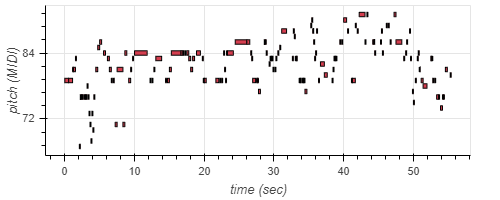

In [7]:
# This creates a MIDI file out of the output Note Sequence.
note_seq.sequence_proto_to_midi_file(sequence, 'sample.mid')

# Download the file
files.download('sample.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>